In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

ROOT_DIR = os.getcwd()
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import custom
%matplotlib inline 
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [3]:
custom_WEIGHTS_PATH = 'mask_rcnn_score_card_0009.h5'

In [4]:
config = custom.CustomConfig()
custom_DIR = os.path.join(ROOT_DIR, "datasets")

In [5]:
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [6]:
DEVICE = "/cpu:0" 
TEST_MODE = "inference"

In [7]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [8]:
dataset = custom.CustomDataset()
dataset.load_custom(custom_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 10
Classes: ['BG', 'score', 'time']


In [9]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [10]:
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

Loading weights  mask_rcnn_score_card_0009.h5


In [17]:
import cv2
image = cv2.imread('3.jpg')
image_resized, window, scale, paddings, _ = utils.resize_image(
    image,
    min_dim=800,
    max_dim=1024,
    mode='square'
)

image_padded, window, scale, paddings, _ = utils.resize_image(
    image,
    min_dim=1280,
    max_dim=1280,
    mode='square'
)

In [18]:
result = model.detect([image_resized], verbose=1)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


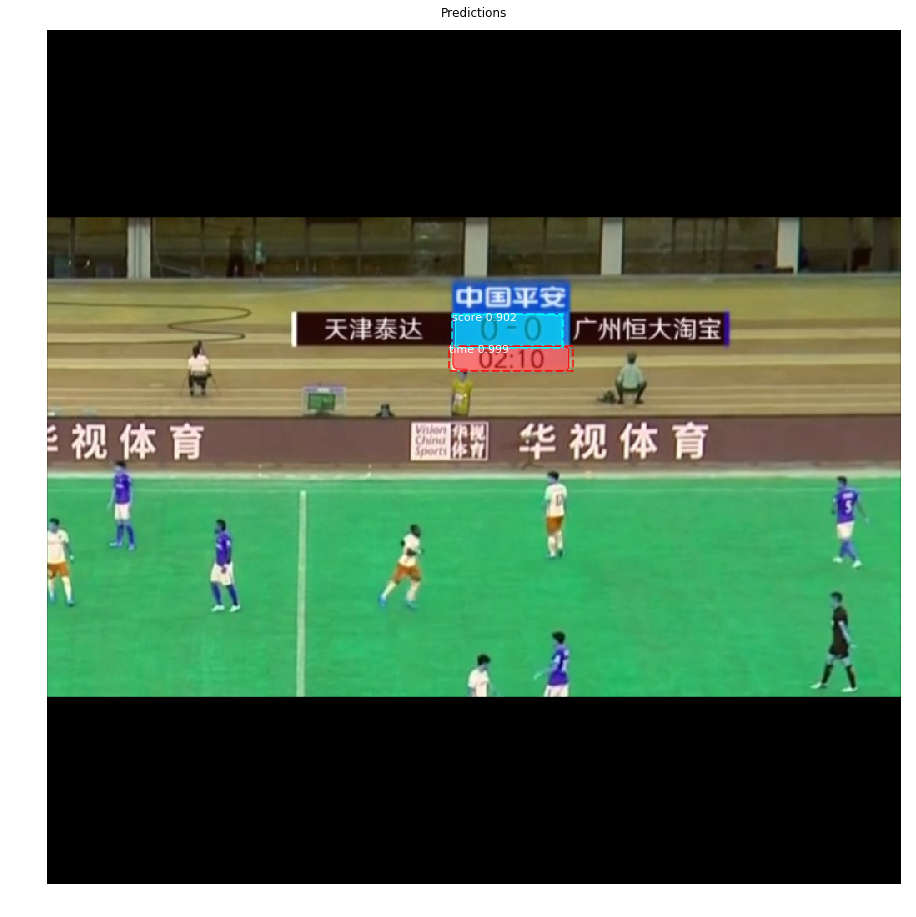

In [19]:
ax = get_ax(1)
r = result[0]
visualize.display_instances(image_resized, r['rois'], r['masks'], r['class_ids'],
                           dataset.class_names, r['scores'], ax=ax,
                           title='Predictions')

In [47]:
p = r['masks'][:,:,0].flatten()
p0 = np.where(p == True)[0][0]
p1 = np.where(p == True)[0][-1]

In [48]:
x0 = p0//image_resized.shape[0]
y0 = p0%image_resized.shape[0]
x1 = p1//image_resized.shape[0]
y1 = p1%image_resized.shape[0]

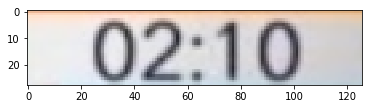

In [49]:
plt.imshow(image_resized[x0:x1, y0:y1, ::-1])

In [50]:
image_resized[x0:x1, y0:y1, ::-1].shape

(28, 126, 3)

In [51]:
len(r['class_ids'])

2

In [52]:
import skimage

In [53]:
def split_x(img):
    skimage.io.imshow(img)
    ban = []
    last_i = 0
    for i in range(img.shape[1]):
        c = np.count_nonzero(img[:, i] < .3)
        if c > img.shape[0]*.8:
            if i - last_i > 3:
                plt.plot([last_i,last_i], [0,img.shape[0]], c='yellow')
                plt.plot([i,i], [0,img2.shape[0]], c='green')
                ban.append((last_i,i))

            last_i = i
    if i != last_i:
        plt.plot([last_i,last_i], [0,img.shape[0]], c='yellow')
        plt.plot([i,i], [0,img.shape[0]], c='green')
        ban.append((last_i,i))

    chars = []
    for y0, y1 in ban:
        img_sub = img[:, y0:y1]
        chars.append(img_sub)
    return chars

def split_y(img):
    plt.figure()
    skimage.io.imshow(img)
    
    last_i = 0
    ban = []
    for i in range(img.shape[0]):
        c = np.count_nonzero(img[i,:] < .3)
        if c > img.shape[1]*.9:
            if i - last_i > 3:
                plt.plot([0, img.shape[1]],[last_i,last_i], c='yellow')
                plt.plot([0, img.shape[1]],[i,i], c='green')
                ban.append((last_i, i))
            last_i = i
    if i != last_i:
        plt.plot([0, img.shape[1]],[last_i,last_i], c='yellow')
        plt.plot([0, img.shape[1]],[i,i], c='green')
        ban.append((last_i, i))
    
    for r0, r1 in ban:
        if r1 - r0 < img.shape[0]/3:
            continue

        img2 = img[r0:r1,:]
        s_max = max(img2.shape)

        pad_w = int((s_max - img2.shape[0])/2)
        pad_h = int((s_max - img2.shape[1])/2)

        img2 = np.pad(img2, ((pad_w,pad_w), (pad_h,pad_h)), mode='constant', constant_values=np.mean(img))
        img2 = skimage.transform.resize(img2, (20,20), mode='reflect', anti_aliasing=True)
        
        return img2

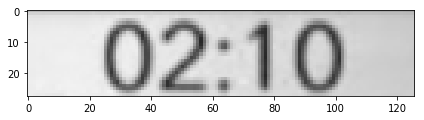

In [54]:
img2 = skimage.color.rgb2gray(image_resized[x0:x1, y0:y1, :])
skimage.io.imshow(img2)

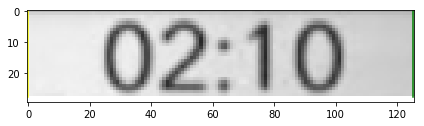

In [55]:
chars = split_x(img2)

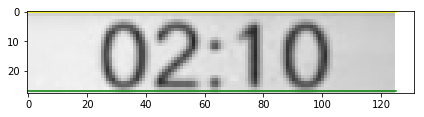

In [56]:
chars2 = np.array([split_y(c) for c in chars])